In [210]:
# Import libraries
import os
import re
import nltk
import pickle
import urllib
import string
import sqlite3
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from sklearn import metrics
from bs4 import BeautifulSoup
from argparse import Namespace
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.stem import PorterStemmer
from gensim.models import KeyedVectors
from sklearn.metrics import roc_auc_score
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
warnings.filterwarnings("ignore")

color = sns.color_palette()

In [211]:
# Read train data
df = pd.read_csv('address_matching_data.csv', na_values='?')
print("Number of data points:",df.shape)

Number of data points: (28235, 31)


In [212]:
# Read test data
df_test = pd.read_csv('address_matching_test.csv', na_values='?')
print("Number of data points:",df_test.shape)

Number of data points: (6230, 30)


In [213]:
df.sample(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
14047,1224#1232,0.523280,0.37037,0.434783,0.210526,1.000000,1.0,1.0,1.0,1.0,...,0.727273,0.5,NaN,NaN,1.0,1.00,n,m,s,1
9770,4307#4309,1.000000,1.00000,1.000000,1.000000,0.857143,0.4,1.0,1.0,1.0,...,1.000000,1.0,NaN,NaN,NaN,NaN,s,m,n,1
8096,320#323,1.000000,1.00000,0.944444,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1
21656,3944#3943,0.241667,0.06250,0.000000,0.058824,1.000000,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,0.5,0.25,m,m,n,-1
8873,1390#1412,0.500000,0.50000,0.357143,0.529412,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1


In [214]:
df_test.sample(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality
6040,1978#1980,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s
1672,8836#8843,0.857143,0.857143,0.823529,0.833333,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s
2891,15096#15097,0.466667,0.400000,0.307692,0.157895,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.5,0.2,m,m,n
1482,2192#2230,0.571429,0.571429,0.344828,0.379310,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s
4127,2011#2029,0.571429,0.500000,0.483871,0.351351,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s


In [215]:
# find duplicate data
df[df.duplicated(subset='id')].shape

(414, 31)

In [216]:
df[df.id == '12258#12259']

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
22490,12258#12259,0.188571,0.000000,0.157895,0.000000,NaN,NaN,NaN,NaN,NaN,...,0.400000,0.222222,NaN,NaN,NaN,NaN,n,m,n,-1
27520,12258#12259,0.590909,0.563636,0.543478,0.489362,1.0,1.0,1.0,1.0,1.0,...,0.545455,0.200000,NaN,NaN,0.8,0.5,n,m,n,-1


In [217]:
# drop duplicate data
df.drop_duplicates(subset='id', keep='first', inplace=True)
print(df.shape)

(27821, 31)


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27821 entries, 0 to 28234
Data columns (total 31 columns):
id                            27821 non-null object
name_levenshtein_simple       27821 non-null float64
name_trigram_simple           27821 non-null float64
name_levenshtein_term         27821 non-null float64
name_trigram_term             27821 non-null float64
city_levenshtein_simple       9834 non-null float64
city_trigram_simple           9834 non-null float64
city_levenshtein_term         9834 non-null float64
city_trigram_term             9834 non-null float64
zip_levenshtein_simple        7607 non-null float64
zip_trigram_simple            7607 non-null float64
zip_levenshtein_term          7607 non-null float64
zip_trigram_term              7607 non-null float64
street_levenshtein_simple     8150 non-null float64
street_trigram_simple         8150 non-null float64
street_levenshtein_term       8150 non-null float64
street_trigram_term           8150 non-null float64
web

In [219]:
df.describe()

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,website_trigram_simple,website_levenshtein_term,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,is_match
count,27821.000000,27821.000000,27821.000000,27821.000000,9834.000000,9834.000000,9834.000000,9834.000000,7607.000000,7607.000000,...,1807.000000,1807.000000,1807.000000,11614.000000,11614.000000,689.000000,689.000000,18162.000000,18162.000000,27821.000000
mean,0.630484,0.566405,0.538959,0.512527,0.882605,0.853599,0.867607,0.853920,0.893279,0.836168,...,0.786666,0.760340,0.713917,0.848102,0.773858,0.765616,0.654163,0.891767,0.834088,0.450415
std,0.304539,0.368499,0.324915,0.372035,0.250899,0.303910,0.275152,0.306377,0.248651,0.321806,...,0.260502,0.285611,0.333915,0.250323,0.341036,0.280800,0.384489,0.216502,0.308442,0.892835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.028219,0.061856,0.025316,0.100000,0.000000,0.100000,0.047619,0.000000,0.000000,-1.000000
25%,0.368056,0.233333,0.250000,0.150000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.564103,0.484611,0.352146,0.727273,0.437500,0.500000,0.263158,1.000000,1.000000,-1.000000
50%,0.666667,0.666667,0.478261,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.966667,0.978495,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,0.888889,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


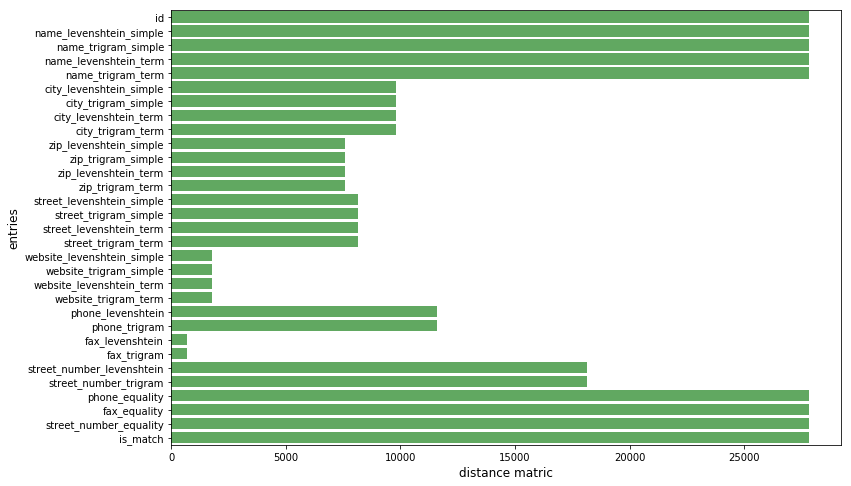

In [220]:
# check number of non null values in each column
not_null = pd.DataFrame(columns=['column', 'count'])
column = df.columns
for index, col in enumerate(list(column)):
    not_null.loc[index] = {'column':col, 'count': df[col].count()}

plt.figure(figsize=(12,8))
sns.barplot(not_null['count'], not_null['column'], alpha=0.8, color=color[2])
plt.xlabel('distance matric', fontsize=12)
plt.ylabel('entries', fontsize=12)
plt.show()


In [221]:
df.sample(4)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
23288,2895#2915,0.800000,0.800000,0.764706,0.777778,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,m,m,s,1
2576,1275#1282,0.500000,0.500000,0.350000,0.400000,0.833333,0.333333,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,m,m,n,1
26969,8906#8911,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,1.000000,1.0,NaN,NaN,NaN,NaN,s,m,n,1
16907,2208#2217,0.333333,0.333333,0.333333,0.380952,NaN,NaN,NaN,NaN,NaN,...,0.363636,0.2,NaN,NaN,1.0,1.0,n,m,s,1


In [222]:
# There are catagorial data columns in train data
# use lable encoding and one hot encoding to make it numerical value
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df.iloc[:, df.columns.get_loc('phone_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('phone_equality')]).reshape(df.shape[0], 1)
df.iloc[:, df.columns.get_loc('fax_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('fax_equality')])
df.iloc[:, df.columns.get_loc('street_number_equality')] = labelencoder.fit_transform(df.iloc[:, df.columns.get_loc('street_number_equality')])

df.head(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality,is_match
0,1204#1207,0.666667,0.666667,0.400000,0.526316,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
1,1272#1279,0.666667,0.666667,0.411765,0.444444,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2,1
2,6258#6259,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1
3,16076#16077,0.565476,0.333333,0.260870,0.189189,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,0.0,0.0,2,0,1,-1
4,2666#2671,0.666667,0.666667,0.500000,0.518519,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2,1


In [223]:
# There are catagorial data columns in test data
# use lable encoding and one hot encoding to make it numerical value
labelencoder_test = LabelEncoder()

df_test.iloc[:, df_test.columns.get_loc('phone_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('phone_equality')]).reshape(df_test.shape[0], 1)
df_test.iloc[:, df_test.columns.get_loc('fax_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('fax_equality')])
df_test.iloc[:, df_test.columns.get_loc('street_number_equality')] = labelencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('street_number_equality')])

df_test.head(5)

,id,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,...,website_trigram_term,phone_levenshtein,phone_trigram,fax_levenshtein,fax_trigram,street_number_levenshtein,street_number_trigram,phone_equality,fax_equality,street_number_equality
0,7221#7218,0.703704,0.666667,0.680000,0.533333,1.000000,1.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,NaN,NaN,1.0,1.0,2,0,2
1,2393#2398,1.000000,1.000000,0.520000,1.000000,0.666667,0.666667,0.454545,0.5,1.0,...,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0,2
2,2509#2510,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,2,0,1
3,3695#3700,0.111310,0.000000,0.095238,0.000000,1.000000,1.000000,1.000000,1.0,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,15918#15955,0.175000,0.074074,0.153846,0.095238,1.000000,1.000000,1.000000,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1


In [224]:
# one hot encoding for train

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder(sparse=False)

print(df.shape)

temp1 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('phone_equality')].reshape(-1, 1))
ohe1 = pd.DataFrame(temp1, columns=['sne_s1','sne_m1','sne_n1'])

print(ohe1.shape)

temp2 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('fax_equality')].reshape(-1, 1))
ohe2 = pd.DataFrame(temp2, columns=['sne_s2','sne_m2','sne_n2'])
print(ohe2.shape)
temp3 = onehotencoder.fit_transform(df.iloc[:, df.columns.get_loc('street_number_equality')].reshape(-1, 1))
ohe3 = pd.DataFrame(temp3, columns=['sne_s3','sne_m3','sne_n3'])
print(ohe3.shape)
df1 = pd.concat([df, ohe1, ohe2, ohe3], axis=1)
print(df1.shape)

(27821, 31)
(27821, 3)
(27821, 3)
(27821, 3)
(28223, 40)


In [225]:
# one hot encoding for test

onehotencoder_test = OneHotEncoder(sparse=False)

temp1 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('phone_equality')].reshape(-1, 1))
ohe1 = pd.DataFrame(temp1, columns=['sne_s1','sne_m1','sne_n1'])

print(ohe1.shape)

temp2 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('fax_equality')].reshape(-1, 1))
ohe2 = pd.DataFrame(temp2, columns=['sne_s2','sne_m2','sne_n2'])
print(ohe2.shape)
temp3 = onehotencoder_test.fit_transform(df_test.iloc[:, df_test.columns.get_loc('street_number_equality')].reshape(-1, 1))
ohe3 = pd.DataFrame(temp3, columns=['sne_s3','sne_m3','sne_n3'])
print(ohe3.shape)
df_test1 = pd.concat([df_test, ohe1, ohe2, ohe3], axis=1)
print(df_test1.shape)

(6230, 3)
(6230, 3)
(6230, 3)
(6230, 39)


In [226]:
# drop columns from train data

df1 = df1.drop(['id','phone_equality','fax_equality','street_number_equality'], axis=1)
df1.shape

(28223, 36)

In [227]:
# drop columns from test data

df_test_id = df_test1.id
df_test1 = df_test1.drop(['id','phone_equality','fax_equality','street_number_equality'], axis=1)
df_test1.shape

(6230, 35)

In [228]:
# check class embalance

for i, j in df.groupby('is_match'):
    print(i, j.is_match.count())

-1 7645
1 20176


In [229]:
# replace na value of each column with mean of that column in train data

df2 = df1.copy()
column = df2.select_dtypes(include=[np.number]).columns.tolist()
for col in column:
    df2.loc[df2[col].isna(), col] = df2.loc[df2[col].notna(), col].mean()

df2.shape

(28223, 36)

In [230]:
# replace na value of each colun with mean of that column in test data

df_test2 = df_test1.copy()
column = df_test2.select_dtypes(include=[np.number]).columns.tolist()
for col in column:
    df_test2.loc[df_test2[col].isna(), col] = df_test2.loc[df_test2[col].notna(), col].mean()

# df3 = df2.fillna(0.5)
df_test2.shape

(6230, 35)

In [231]:
df_test2.sample(4)

,name_levenshtein_simple,name_trigram_simple,name_levenshtein_term,name_trigram_term,city_levenshtein_simple,city_trigram_simple,city_levenshtein_term,city_trigram_term,zip_levenshtein_simple,zip_trigram_simple,...,street_number_trigram,sne_s1,sne_m1,sne_n1,sne_s2,sne_m2,sne_n2,sne_s3,sne_m3,sne_n3
4063,0.223810,0.016807,0.148148,0.025000,0.887698,0.857783,0.878316,0.859965,0.887348,0.820223,...,0.827768,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4003,0.571429,0.571429,0.206897,0.482759,1.000000,1.000000,1.000000,1.000000,0.887348,0.820223,...,1.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1881,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
54,0.119048,0.000000,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,...,0.827768,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


-1.0 7645
0.4504151540203443 402
1.0 20176


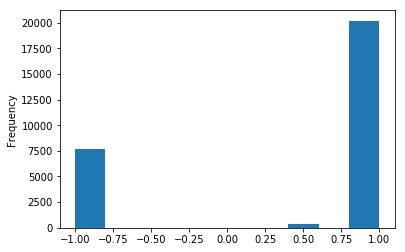

In [232]:
df2.is_match.plot.hist()
for i, j in df2.groupby('is_match'):
    print(i, j.is_match.count())

In [233]:
# deal with unbalanced data with upsampling technique

from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df2[df2.is_match==1]
df_minority = df2[df2.is_match==-1]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df3 = pd.concat([df_majority, df_minority_upsampled])
df3.is_match.value_counts()

-1.0    20176
 1.0    20176
Name: is_match, dtype: int64

In [234]:
# Train test data seperation

X = df3.drop(['is_match'], axis=1)
y = df3['is_match']

print(X.shape)
print(y.shape)

(40352, 35)
(40352,)


In [235]:
# modified confusion matrix implementation 

def modified_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print(C)
    tp = C[1][1]
    tn = C[0][0]
    fp = C[0][1]
    fn = C[1][0]
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    score = (tpr + 2 * tnr)/3
    return score
    

In [236]:
# train test spliting

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # this is random splitting
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(28246, 35) (28246,)
(12106, 35) (12106,)


{'n_neighbors': 21}
0.974299349489
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='uniform')


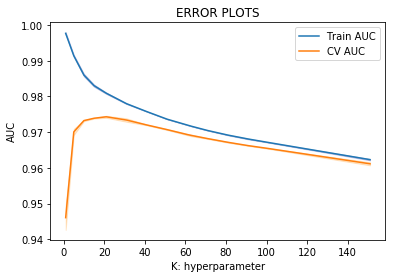

In [237]:
# KNN with GridSearchCV

neigh = KNeighborsClassifier()
parameters = {
    'n_neighbors':[1, 5, 10, 15, 21, 31, 41, 51, 61, 63, 71, 81, 91, 101, 151], 
}

clf = GridSearchCV(neigh, parameters, cv=3, scoring='roc_auc', return_train_score=True)
clf.fit(X_train, y_train)

print(clf.best_params_)
print(clf.best_score_)
print(clf.best_estimator_)

# AUC curve for train and cv
train_auc= clf.cv_results_['mean_train_score']
train_auc_std= clf.cv_results_['std_train_score']
cv_auc = clf.cv_results_['mean_test_score'] 
cv_auc_std= clf.cv_results_['std_test_score']

plt.plot(parameters['n_neighbors'], train_auc, label='Train AUC')
plt.gca().fill_between(parameters['n_neighbors'],train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
plt.plot(parameters['n_neighbors'], cv_auc, label='CV AUC')
plt.gca().fill_between(parameters['n_neighbors'],cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

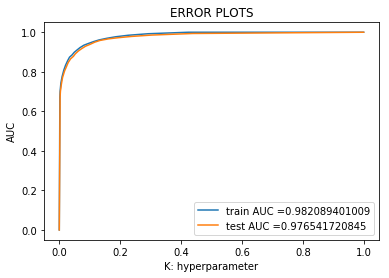

--------------------------------------------------
Train confusion matrix
[[13275   825]
 [ 1266 12880]]
0.931161153242
Test confusion matrix
[[5697  379]
 [ 574 5456]]
0.926685386614


In [238]:
# KNN with best params

clf.best_estimator_.fit(X_train, y_train)

# ROC AUC curve for train test
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("-"*50)

# modified accuracy score
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(modified_confusion_matrix(y_train, clf.predict(X_train)))
print("Test confusion matrix")
print(modified_confusion_matrix(y_test, clf.predict(X_test)))

In [160]:
y_test = clf.predict(df_test2)

array([ 1.,  1.,  1., ..., -1.,  1.,  1.])

In [ ]:
final_df = pd.DataFrame(data = { 'is_match': list(y_test)})

In [201]:
final_df = pd.concat([df_test_id.to_frame(), final_df], ignore_index=True, axis=1)

In [208]:
final_df.columns=['id', 'is_match']
final_df.to_csv('result.csv', index=False)

In [240]:
# Create the parameter grid 
features = list(X_train.columns)
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50],
    'max_features': [len(features)],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [4, 8],
    'n_estimators': [5, 10, 50] # of trees
}

In [241]:
# Initialize random forest
forest = RandomForestClassifier()

In [242]:
# Instantiate grid search
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=3, 
                           n_jobs=-1, verbose=1)

In [243]:
# Fit grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 162 out of 162 | elapsed:  1.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [245]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 35,
 'min_samples_leaf': 3,
 'min_samples_split': 4,
 'n_estimators': 50}

In [246]:
best_forest = grid_search.best_estimator_
best_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features=35, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

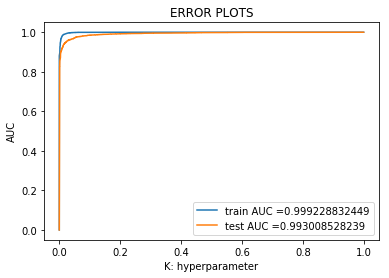

--------------------------------------------------
Train confusion matrix
[[13960   140]
 [  247 13899]]
0.987560359226
Test confusion matrix
[[5934  142]
 [ 289 5741]]
0.968443897112


In [247]:
train_fpr, train_tpr, thresholds = roc_curve(y_train, best_forest.predict_proba(X_train)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_forest.predict_proba(X_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

print("-"*50)

from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(modified_confusion_matrix(y_train, best_forest.predict(X_train)))
print("Test confusion matrix")
print(modified_confusion_matrix(y_test, best_forest.predict(X_test)))

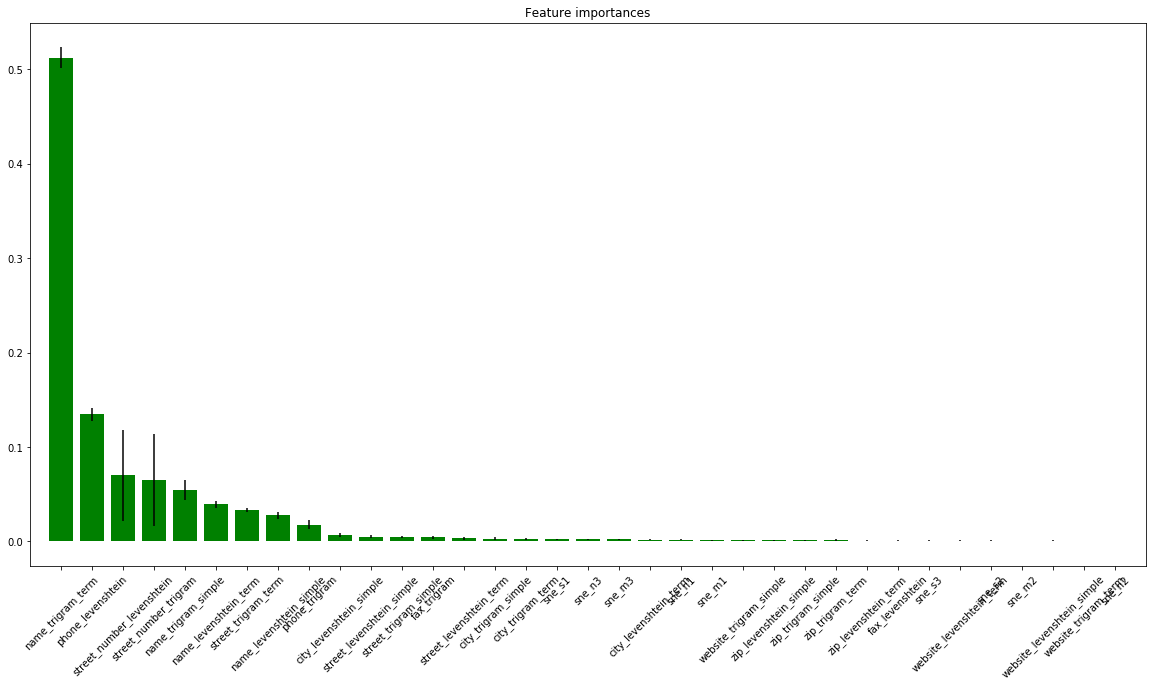

name_trigram_term - 0.513
phone_levenshtein - 0.135
street_number_levenshtein - 0.070
street_number_trigram - 0.065
name_trigram_simple - 0.054
name_levenshtein_term - 0.039
street_trigram_term - 0.033
name_levenshtein_simple - 0.027
phone_trigram - 0.018
city_levenshtein_simple - 0.007
street_levenshtein_simple - 0.005
street_trigram_simple - 0.004
fax_trigram - 0.004
street_levenshtein_term - 0.003
city_trigram_simple - 0.003
city_trigram_term - 0.002
sne_s1 - 0.002
sne_n3 - 0.002
sne_m3 - 0.002
city_levenshtein_term - 0.002
sne_n1 - 0.002
sne_m1 - 0.001
website_trigram_simple - 0.001
zip_levenshtein_simple - 0.001
zip_trigram_simple - 0.001
zip_trigram_term - 0.001
zip_levenshtein_term - 0.001
fax_levenshtein - 0.001
sne_s3 - 0.001
website_levenshtein_term - 0.000
sne_s2 - 0.000
sne_m2 - 0.000
website_levenshtein_simple - 0.000
website_trigram_term - 0.000
sne_n2 - 0.000


In [249]:
# Feature importances
features = list(X_train.columns)
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
num_features = len(importances)

# Plot the feature importances of the tree
plt.figure(figsize=(20,10))
plt.title("Feature importances")
plt.bar(range(num_features), importances[indices], yerr=std[indices], 
        color="g", align="center")
plt.xticks(range(num_features), [features[i] for i in indices], rotation='45')
plt.xlim([-1, num_features])
plt.show()

# Print values
for i in indices:
    print ("{0} - {1:.3f}".format(features[i], importances[i]))